In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [2]:
x = mydata = np.random.normal(0,1,10000)

(array([   8.,   74.,  462., 1411., 2518., 2820., 1795.,  711.,  176.,
          25.]),
 array([-3.81511853, -3.07925217, -2.34338582, -1.60751947, -0.87165311,
        -0.13578676,  0.6000796 ,  1.33594595,  2.07181231,  2.80767866,
         3.54354502]),
 <a list of 10 Patch objects>)

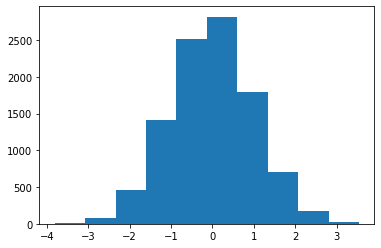

In [3]:
plt.hist(x)

In [4]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
import tensorflow as tf

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

In [5]:
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [6]:
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
#autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []
preds += [encoder.predict(np.linspace(-4,4,10))]

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)))

    y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True

on i= 0
Epoch 1/1
20000/20000 [==============================] - 1s 54us/step - loss: 0.6689
0 0.46469966000000007
Epoch 1/1
10000/10000 [==============================] - 1s 100us/step - loss: -1.4528
on i= 1
Epoch 1/1
20000/20000 [==============================] - 1s 57us/step - loss: 0.7014
1 0.562606895
Epoch 1/1
10000/10000 [==============================] - 1s 108us/step - loss: -1.5035
on i= 2
Epoch 1/1
20000/20000 [==============================] - 1s 61us/step - loss: 0.6864
2 0.5680201199999999
Epoch 1/1
10000/10000 [==============================] - 1s 112us/step - loss: -1.5249
on i= 3
Epoch 1/1
20000/20000 [==============================] - 1s 66us/step - loss: 0.6905
3 0.473675345
Epoch 1/1
10000/10000 [==============================] - 1s 123us/step - loss: -1.5727
on i= 4
Epoch 1/1
20000/20000 [==============================] - 1s 68us/step - loss: 0.6584
4 0.6529487700000001
Epoch 1/1
10000/10000 [==============================] - 1s 127us/step - loss: -1.5322
on i= 5


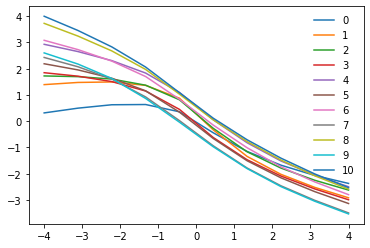

In [7]:
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)

In [8]:
mypreds = combinedModel_classifier.predict(x)

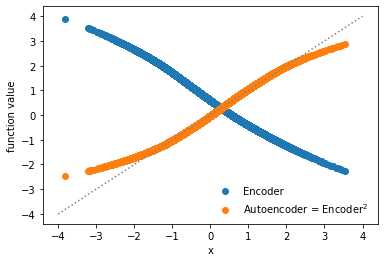

In [13]:
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("function value")
plt.legend(frameon=False)